<a href="https://colab.research.google.com/github/komorimasashi/HIS2024-GenAI/blob/main/Furusato_Tax_Return_Goods_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ふるさと納税返礼品の説明の分析

「茨木市ふるさと納税返礼品「鶏のすき焼き缶」の開発：産学官連携プロジェクト」で集められたデータ．
長岡千賀先生（追手門学院大学）から提供を受けた

長岡千賀. (2020). 製品パッケージと説明コピーの作成に向けた心理学的検討: 茨木市ふるさと納税返礼品 「鶏のすき焼き缶」 の開発. 追手門経営論集; Otemon business management review, 25(2), 51-62.

商品カテゴリ（缶詰，弁当，本製品（鶏のすき焼き缶）），商品名，およびこれらの説明の記述のデータ．


## 分析準備

In [ ]:
!pip install openai
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fo

In [ ]:
import pandas as pd
import openai
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import re
import pandas as pd
from bs4 import BeautifulSoup
import openai
from google.colab import userdata
import seaborn as sns

import japanize_matplotlib
import matplotlib.pyplot as plt

In [ ]:
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')

## テキストデータの前処理

In [ ]:
def clean_text(text):
    # 特殊文字や句読点を削除
    text = re.sub(r"[^\w\s]", " ", text)
    # 単一文字を削除
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    # HTMLタグを削除
    text = re.sub(r"<[^>]*>", " ", text)
    # テキストを小文字化
    text = text.lower()
    # 余分な空白を削除
    text = re.sub(r"\s+", " ", text)
    # 先頭と末尾の空白を削除
    text = text.strip()
    # 全角スペースを削除
    text = re.sub(r'\u3000', '', text)
    # 特定のパターンを置換
    text = re.sub(r"^\('(.+?)',\)$", r'\1', text)
    return text

In [ ]:
# ファイルを読み込む
with open('さとふる缶詰と弁当と本製品説明書き.txt', 'r', encoding='shift_jis') as file:
    content = file.read()

# BeautifulSoupを使ってHTMLを解析
soup = BeautifulSoup(content, 'html.parser')

# データを格納するリストを初期化
data = []

# <H1>と<H2>タグを順に処理
for h1_tag in soup.find_all('h1'):
    category = h1_tag.text.strip()
    h2_tags = h1_tag.find_next_siblings('h2')
    for h2_tag in h2_tags:
        # <H2>タグが次の<H1>までの間にあるかを確認
        if h2_tag.find_previous_sibling('h1') == h1_tag:
            product_name = h2_tag.text.strip()
            description = h2_tag.find_next_sibling(text=True).strip()
            data.append([category, product_name, clean_text(description)])

# データフレームに変換
df = pd.DataFrame(data, columns=['Category', 'Product Name', 'Description'])

# 結果を表示
df

<ipython-input-5-22859152c389>:19: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  description = h2_tag.find_next_sibling(text=True).strip()


,Category,Product Name,Description
0,缶詰,神奈川県産すっぽん満足セット1,神奈川県産丹沢の水で育てた国産すっぽんをぜひ味わってください
1,缶詰,サラダチキン 缶詰 24缶セット2,鶏むね肉を煮た缶詰で ツナ缶の代わりとしても使えます 前処理工程で加熱していないため やわら...
2,缶詰,冷たい肉そば(缶詰乾麺9人分) 3,冬でもつったい 冷たい かほく冷たい肉そば 山形県河北町発祥のソウルフードをご家庭で簡単に召...
3,缶詰,徳重ばあちゃんが受け継いだ「鶯宿梅」の梅肉エキス 4,土づくりからこだわった栽培期間中農薬不使用 自家栽培の在来品種 鶯宿梅 の青梅の青汁だけ 信...
4,缶詰,サラダチキン缶詰(72缶) 5,便利な使い切りサイズで 柔らかく食べやすいサラダチキンです サラダやパスタはもちろん 炊き込...
...,...,...,...
112,弁当,いいとこ鶏 J11,もち米入りの味付けご飯に刻みのりを敷き 岡山県産の備中森林鶏を色々な味のバリエーションでトッ...
113,弁当,鶏めし弁当 J12,茶飯 鶏そぼろ 海苔 鶏の照り焼き コールドチキン 赤こんにゃく 舞茸入り肉団子 栗甘露煮 ...
114,弁当,じゅうじゅう亭 J13,
115,弁当,suica弁当J20,


## ChatGPTによる埋込み

In [ ]:
from openai import OpenAI

client = openai.OpenAI(api_key=OPENAI_API_KEY)


def get_embedding(text, model="text-embedding-3-small", dim=None):
    text = text.replace("\n", " ")
    if dim is None:
        return client.embeddings.create(input=[text], model=model).data[0].embedding
    else:
        return (
            client.embeddings.create(input=[text], model=model, dimensions=dim)
            .data[0]
            .embedding
        )

In [ ]:
# Embeddingを作成
embeddings = []
successful_indices = []

for i, description in enumerate(df['Description']):
  try:
    embedding = get_embedding(
        text=description,
        model="text-embedding-3-small"
    )
    embeddings.append(embedding)
    successful_indices.append(i)
  except Exception as e:
    print(f"Embedding failed for index {i}")

# 成功した行だけをデータフレームに残す
df = df.iloc[successful_indices].reset_index(drop=True)

Embedding failed for index 114
Embedding failed for index 115


1536次元のベクトルとして表現される

In [ ]:
embeddings_array = np.array(embeddings)
embeddings_array.shape

(115, 1536)

## 可視化

In [ ]:
# フォントの設定
plt.rcParams['font.family'] = 'IPAPGothic'
japanize_matplotlib.japanize()

### クラスタ分析

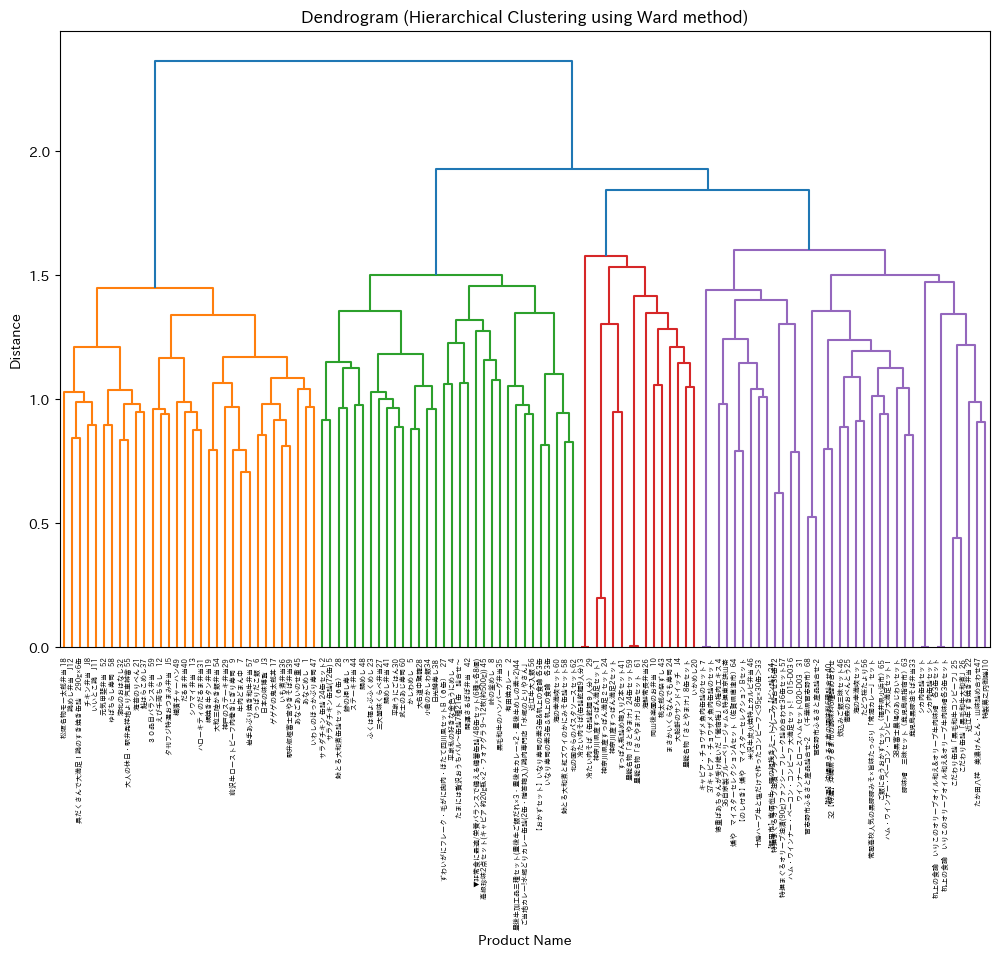

In [ ]:
# Ward法による階層型クラスタリング
linkage_matrix = linkage(embeddings_array, method='ward')
clusters = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward').fit_predict(embeddings_array)

# クラスタリング結果をデータフレームに追加
df['Cluster'] = clusters

# デンドログラムをプロット
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df['Product Name'].values, leaf_rotation=90)
plt.title('Dendrogram (Hierarchical Clustering using Ward method)')
plt.xlabel('Product Name')
plt.ylabel('Distance')
plt.show()


### t-SNEによる散布図のプロット

In [ ]:
# t-SNEで次元削減
embeddings_array = np.array(embeddings)
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embeddings_array)

# データフレームにt-SNEの結果を追加
df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]


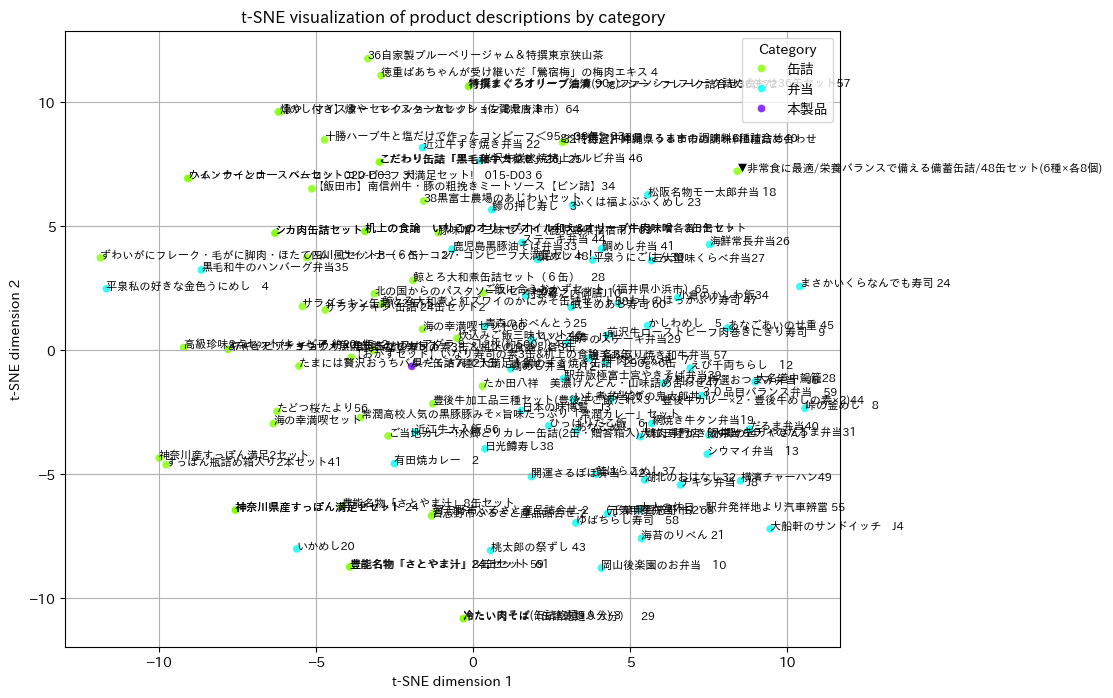

In [ ]:
# 色をカテゴリごとに設定
unique_categories = df['Category'].unique()
palette = sns.color_palette("hsv", len(unique_categories))
category_color_mapping = {category: palette[i] for i, category in enumerate(unique_categories)}

# 散布図をプロット
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Category",
    palette=category_color_mapping,
    data=df,
    legend="full",
    alpha=0.8
)

# 各ポイントに商品名を表示
for i, product_name in enumerate(df['Product Name']):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], product_name, fontsize=8)

plt.title('t-SNE visualization of product descriptions by category')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.show()

## BERT（おまけ）

日本語pre-trained model（東北大学）を使用

In [ ]:
!pip install transformers
!pip install torch
!pip install fugashi
!pip install ipadic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 73.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=96c1f89700d68fb9c0ac80b5884be08e324b73bcc0773424f73e38b3e307e06d
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
import pandas as pd
from transformers import BertModel, BertJapaneseTokenizer
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

In [ ]:
#モデルとトークナイザの設定
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"#単語

tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
# Embeddingを作成
embeddings = []
successful_indices = []

for i, description in enumerate(df['Description']):
  try:
    inputs = tokenizer(description, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    with torch.no_grad():
        outputs = model(**inputs)#モデルにトークナイズしたテキストを入力
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()#
    embeddings.append(cls_embedding[0])#リストに追加
    successful_indices.append(i)
  except Exception as e:
    print(f"Embedding failed for index {i}")

# 成功した行だけをデータフレームに残す
df = df.iloc[successful_indices].reset_index(drop=True)

In [ ]:
embeddings_array = np.array(embeddings)
embeddings_array.shape

(115, 768)

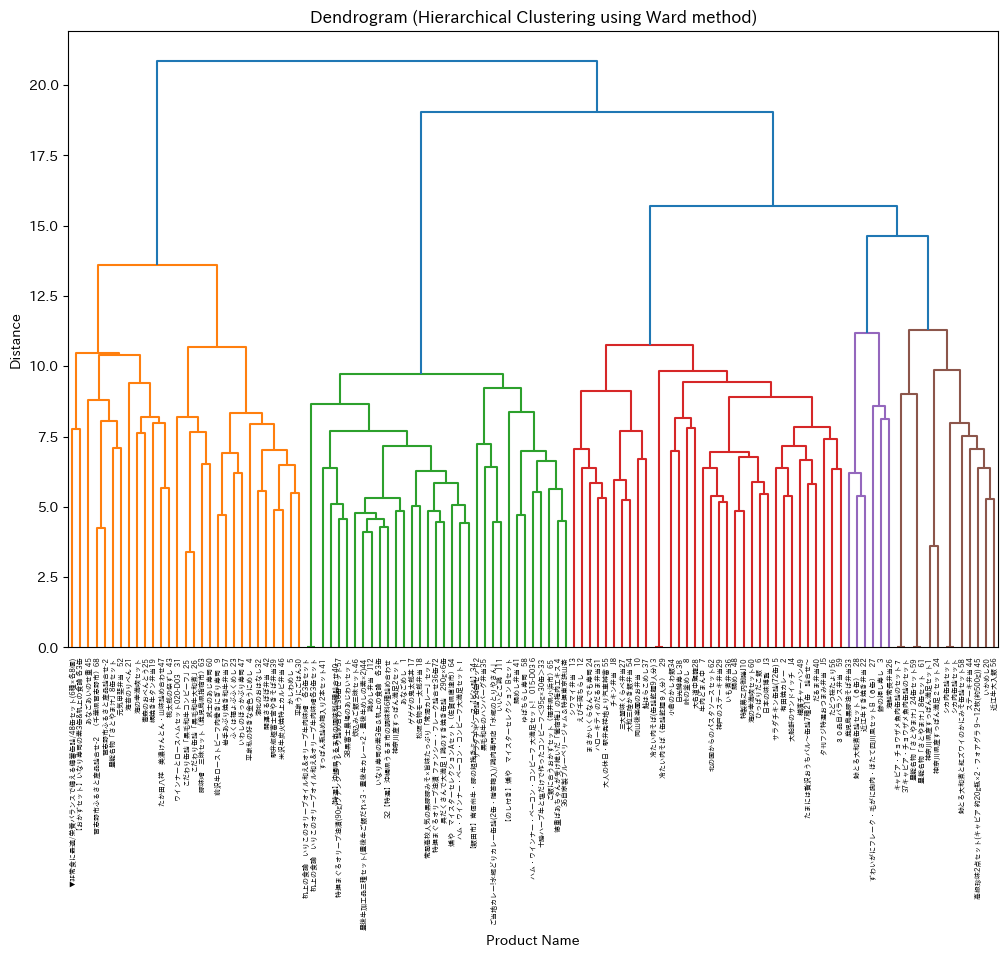

In [ ]:
# Ward法による階層型クラスタリング
linkage_matrix = linkage(embeddings_array, method='ward')
clusters = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward').fit_predict(embeddings_array)

# クラスタリング結果をデータフレームに追加
df['Cluster'] = clusters

# デンドログラムをプロット
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df['Product Name'].values, leaf_rotation=90)
plt.title('Dendrogram (Hierarchical Clustering using Ward method)')
plt.xlabel('Product Name')
plt.ylabel('Distance')
plt.show()